# Cat and Dog Classification

### [2024.02.21] 이상혁

### 개요
- [출처] 딥러닝 파이토치 교과서 5장 3절의 전이학습
- 전이학습을 통한 강아지, 고양이 이미지 분류

### 0. GPU Configuration

💻빠른 연산을 위해 Tensorflow에서 **GPU**를 사용할 수 있도록 설정해준다.

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# 시드 고정
SEED = 221

if device == 'cuda':
    torch.cuda.manual_seed_all(SEED)
else:
    torch.manual_seed(SEED)

### 1. Libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import datetime
import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import copy
import glob # for file handling
import cv2 # open source cv library
import shutil

import torch
import torchvision # CV
import torchvision.transforms as transforms # pre-processing
import torchvision.models as models # PyTorch networks
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [4]:
sys.path.append('C:/Python_Programs/Pytorch/3. Dog&Cat Classification')

### 2. Brief Info

이번에 진행할 주제는 강아지와 고양이 이미지 분류이다. 그리고 이를 **전이학습**을 통해서 해결한다.

1. 전이학습을 사용하는 이유?
- 학습을 위한 대량의 데이터셋은 언제나 구하기 어렵다.
- 따라서 대량의 데이터(ImageNet)를 바탕으로 사전 학습한 신경망 모델의 가중치를 내가 해결하고자 하는 문제에 적용하는 방법을 사용한다.
- 이를 전이학습이라고 한다.

2. 전이학습에는 어떤 방법이 있는가?
- **특성 추출 기법(Feature Extraction)** : 사전 학습된 모델을 가져온 후 **마지막 완전연결층**만 새롭게 만든다. 따라서 나머지 계층의 가중치는 갱신되지 않는다.
- **미세 조정(Fine-tuning)** : 사전 학습된 모델과 마지막 계층까지 **모두 가중치를 갱신**하는 방법이다. 모델을 목적에 맞게 **재학습**시키는 것이다.

3. 특성 추출은 어떻게 구성되는가?
- 합성곱층과 완전연결층으로 구성된다. 이때 사전 학습된 모델의 합성곱층의 가중치를 내 모델의 합성곱층에 재사용하는 것이다. 그리고 완전연결층만 새롭게 학습시키는 것이다.

4. 사전 훈련된 모델은 어떤게 있는가?
- Xception
- Inception V3
- ResNet 50
- VGG16
- VGG19
- MobileNet

그럼 먼저 필요한 라이브러리를 설치하자

In [5]:
# pip install opencv-python

### 3. Load Data

In [6]:
data_path = 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification/train'

### 4. Pre-processing

In [7]:
# 이미지 augmentation 객체 생성
transform = transforms.Compose(
    [
        transforms.Resize([256, 256]), # 이미지를 256x256 크기로 조정한다.
        transforms.RandomResizedCrop(224), # 이미지를 랜덤한 크기로 자르고 크기를 조정한다. 이는 데이터 augmentation의 용도로 사용된다.
        transforms.RandomHorizontalFlip(), # 이미지를 랜덤하게 수평으로 뒤집는다.
        transforms.ToTensor() # 이미지를 텐서로 변환한다.
])

In [8]:
# 훈련 데이터셋 생성
train_dataset = torchvision.datasets.ImageFolder(data_path, # 경로
                                                 transform=transform # 전처리
                                                 )

- 이후 데이터로더로 불러올 대상(경로)을 지정하고, 방법을 정의한다.

In [9]:
# 데이터로더
train_loader = torch.utils.data.DataLoader(
    train_dataset, # 훈련 데이터
    batch_size = 32, # 배치 크기
    num_workers = 8, # 데이터 불러올 때 수행하는 프로세스 개수(메모리와 연관)
    shuffle = True # 데이터 무작위 셔플 후 불러오기
)

In [10]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 385
    Root location: C:/Python_Programs/Pytorch/3. Dog&Cat Classification/train
    StandardTransform
Transform: Compose(
               Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=warn)
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [11]:
train_loader

데이터를 불러와서 데이터로더로 정의도 마무리했다. 이미지 데이터 몇개를 출력해보자.

In [12]:
# kernel 충돌로 matplotlib.pyplot가 그려지지 않을 때 해결 방법 -> 환경 변수를 설정
os.environ['KMP_DUPLICATE_LIB_OK']='True'

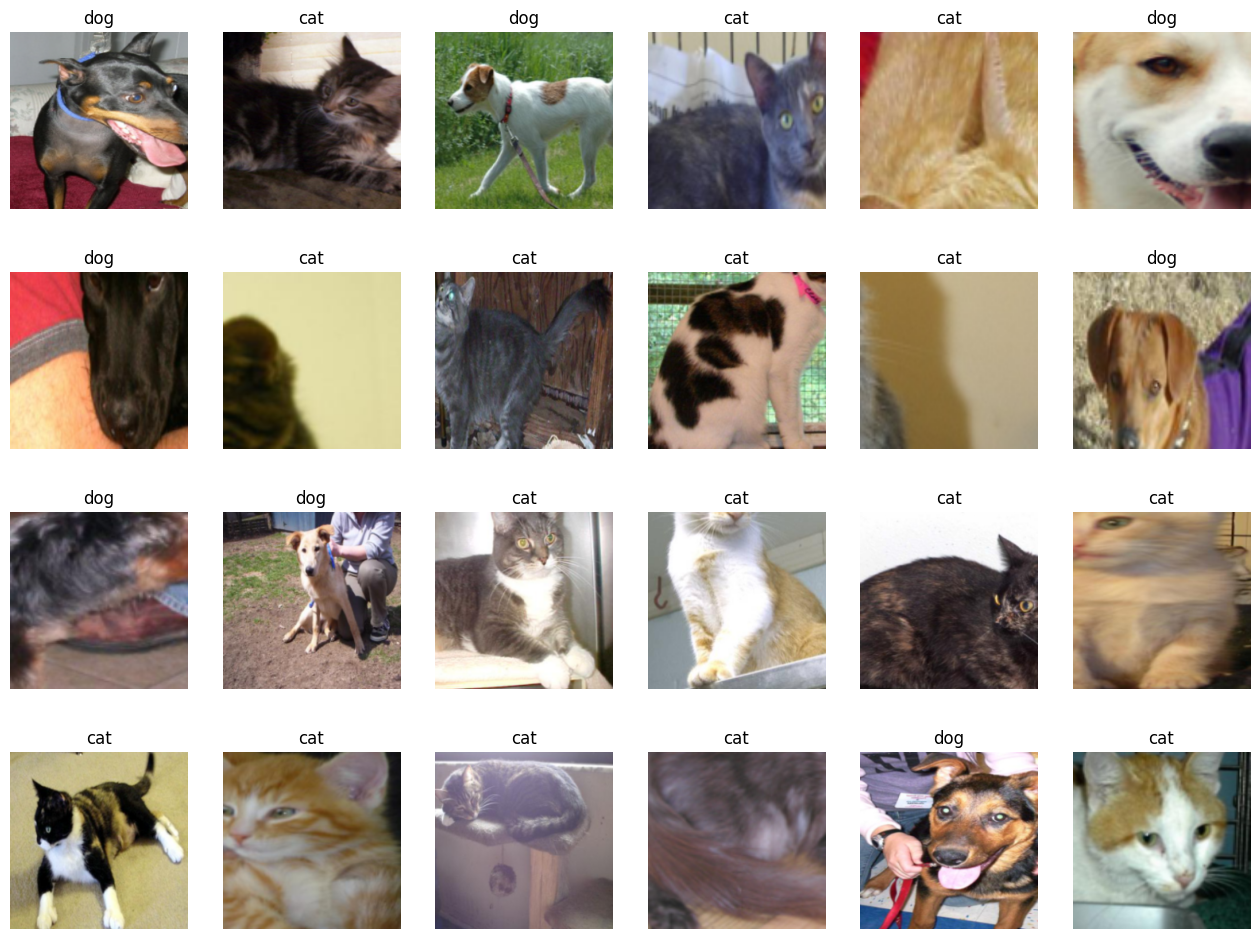

In [13]:
# 데이터로더의 데이터를 하나씩 꺼냄
samples, labels = next(iter(train_loader))

# 레이블 정보
classes = {0 : 'cat', 1 : 'dog'}

# 시각화 설정
fig = plt.figure(figsize=(16,24))

# 24개만 시각화
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()]) # 레이블 정보를 제목으로
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # (3, 224, 244)를 (224, 224, 3) 크기로 만들기 위해 전치

# plot 간격 조절
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

- 이유를 알 수 없지만 매번 PyTorch를 사용하면서 시각화할 때마다 kernel이 죽는 현상이 발생한다. 해결 방법을 찾아봐야겠다.
- (2024.02.22) 해결.. OS 설정을 해줘야 하나보다. 위에 있는 코드를 사용하면 된다.

### 5. Modeling

특성 추출을 위한 모델로는 사전 훈련된 ResNet18 모델을 사용한다.

In [14]:
resnet18 = models.resnet18(pretrained=True)

- 여기서 사용하는 모델은 ResNet18이다. 잔차학습을 한 ResNet은 이미지처리 분야에서 뛰어난 성능을 보인다. 
- ImageNet 데이터베이스의 100만개가 넘는 영상을 이용하여 훈련되었다.
- 물론 다른 ResNet에 비하여 입력 제약이 크다.
- pretrained=True를 설정해서 사전학습된 모델의 가중치를 사용한다.

In [15]:
# ResNet 합성곱층 사용 및 가중치 업데이트 않도록 설정
def set_parameter_requires_grad(model, feature_extracting = True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

set_parameter_requires_grad(resnet18)

In [16]:
# 완전연결계층 추가(이진 분류)
resnet18.fc = nn.Linear(512, 2)

In [17]:
# 파라미터 확인
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0222, -0.0018, -0.0015,  ..., -0.0209,  0.0362,  0.0120],
        [-0.0164, -0.0261, -0.0329,  ..., -0.0351, -0.0405, -0.0403]])
fc.bias tensor([0.0356, 0.0151])


- 완전연결계층의 가중치와 편향을 확인할 수 있다.

In [18]:
# 모델 객체
model = models.resnet18(pretrained=True)

# 합성곱층 가중치 고정
for param in model.parameters():
    param.requires_grad = False

# 완전연결계층 추가
model.fc = nn.Linear(512, 2)

# 완전연결계층 가중치 업데이트
for param in model.fc.parameters():
    param.requires_grad = True

# 옵티마이저
optimizer = torch.optim.Adam(model.fc.parameters())

# 손실함수
cost = torch.nn.CrossEntropyLoss()

# 모델 확인
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# 모델 학습을 위한 함수 작성
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_hist = []
    loss_hist = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*10)

        running_loss = 0.0
        running_correct = 0

        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)

            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과
            running_correct += torch.sum(preds==labels.data) # 출력 결과와 레이블이 동일한지 확인
        
        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차
        epoch_acc = running_correct.double() / len(dataloaders.dataset) # 평균 정확도

        print('Loss : {:.4f} Acc : {:.4f}'.format(epoch_loss, epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_hist.append(epoch_acc.item())
        loss_hist.append(epoch_loss)

        torch.save(model.state_dict(), 
                   os.path.join('C:/Python_Programs/Pytorch/3. Dog&Cat Classification', '{0:0=2d}.pth'.format(epoch)))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Accuracy : {:.4f}'.format(best_acc))

    return acc_hist, loss_hist

이번에는 ResNet에 추가된 완전연결층 학습을 하도록 설정한다. 학습으로 얻어지는 파라미터를 옵티마이저에 전달해서 최종적으로는 모델에 전달되도록 한다.

In [20]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


- weight와 bias 값이 업데이트되고 옵티마이저에 전달된다.

In [21]:
# 학습 진행
criterion = nn.CrossEntropyLoss()

train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

Epoch 0/12
----------
Loss : 0.6449 Acc : 0.6156

Epoch 1/12
----------
Loss : 0.4339 Acc : 0.8104

Epoch 2/12
----------
Loss : 0.3657 Acc : 0.8364

Epoch 3/12
----------
Loss : 0.3179 Acc : 0.8727

Epoch 4/12
----------
Loss : 0.2734 Acc : 0.8883

Epoch 5/12
----------
Loss : 0.2692 Acc : 0.8831

Epoch 6/12
----------
Loss : 0.2761 Acc : 0.8805

Epoch 7/12
----------
Loss : 0.2099 Acc : 0.9403

Epoch 8/12
----------
Loss : 0.2375 Acc : 0.8909

Epoch 9/12
----------
Loss : 0.2226 Acc : 0.9169

Epoch 10/12
----------
Loss : 0.2520 Acc : 0.8909

Epoch 11/12
----------
Loss : 0.1673 Acc : 0.9481

Epoch 12/12
----------
Loss : 0.1927 Acc : 0.9273

Training complete in 3m 22s
Best Accuracy : 0.9481


- 학습 속도는 약 3분으로 CPU 사용 속도보다 확실히 빠르다.
- 학습 최고 정확도는 94%이다. Train임을 감안해도 매우 높다.
- 이제 test 데이터로 평가해보자.

In [22]:
test_path = 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification/test'

In [23]:
# test 이미지 augmentation 객체 생성
transform = transforms.Compose(
    [
        transforms.Resize(224), # 이미지를 224 크기로 조정한다.
        transforms.CenterCrop(224), # (224, 224) 크기로 crop
        transforms.ToTensor() # 이미지를 텐서로 변환한다.
])

In [24]:
# test 데이터셋 생성
test_dataset = torchvision.datasets.ImageFolder(root=test_path, # 경로
                                                transform=transform # 전처리
                                                )

In [25]:
# 데이터로더
test_loader = torch.utils.data.DataLoader(
    test_dataset, # 훈련 데이터
    batch_size = 32, # 배치 크기
    num_workers = 1, # 데이터 불러올 때 수행하는 프로세스 개수(메모리와 연관)
    shuffle = True # 데이터 무작위 셔플 후 불러오기
)

In [26]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 98
    Root location: C:/Python_Programs/Pytorch/3. Dog&Cat Classification/test
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

In [27]:
test_loader

In [28]:
# evaluation용 함수
def eval_model(model, dataloader, device):
    since = time.time()
    acc_hist = []
    best_acc = 0.0

    saved_model = glob.glob('C:/Python_Programs/Pytorch/3. Dog&Cat Classification/' + '*.pth') # pth 확장자 파일을 가져오기
    saved_model.sort()
    print('Saved Model :', saved_model)

    for model_path in saved_model:
        print('Load Model :', model_path)

        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)

        running_correct = 0

        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad(): # prediction에서는 자동미분 사용하지 않음
                output = model(inputs) 

            _, preds = torch.max(output.data, 1) # array의 최댓값과 인덱스 반환(여기서는 인덱스 반영)
            preds[preds >= 0.5] = 1 # torch.max 값이 0.5보다 크면 correct
            preds[preds < 0.5] = 0 # torch.max 값이 0.5보다 작으면 wrong

            running_correct += preds.eq(labels).int().sum() # preds 배열과 labels 배열이 일치하는지 확인, 일치하는 개수의 합

        epoch_acc = running_correct.double() / len(dataloader.dataset)
        print('Accuracy : {:.4f}'.format(epoch_acc))

        if epoch_acc > best_acc:
            best_acc = epoch_acc

        acc_hist.append(epoch_acc.item())
        print()

    time_elapsed = time.time() - since
    print('Testing complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Accuracy : {:.4f}'.format(best_acc))

    return acc_hist

In [29]:
test_acc_hist = eval_model(resnet18, test_loader, device)

Saved Model : ['C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\00.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\01.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\02.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\03.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\04.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\05.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\06.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\07.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\08.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\09.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\10.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\11.pth', 'C:/Python_Programs/Pytorch/3. Dog&Cat Classification\\12.pth']
Load Model : C:/Python_Programs/Pytorch/3. Dog&Cat Classification\00.pth
Accuracy : 0.8367

Load Model : C:/Python_Programs/Pytorch/3. Dog&Cat Classifica

- Test 결과 94%의 정확도를 보여주고 있다. 상당히 잘 분류하고 있다.

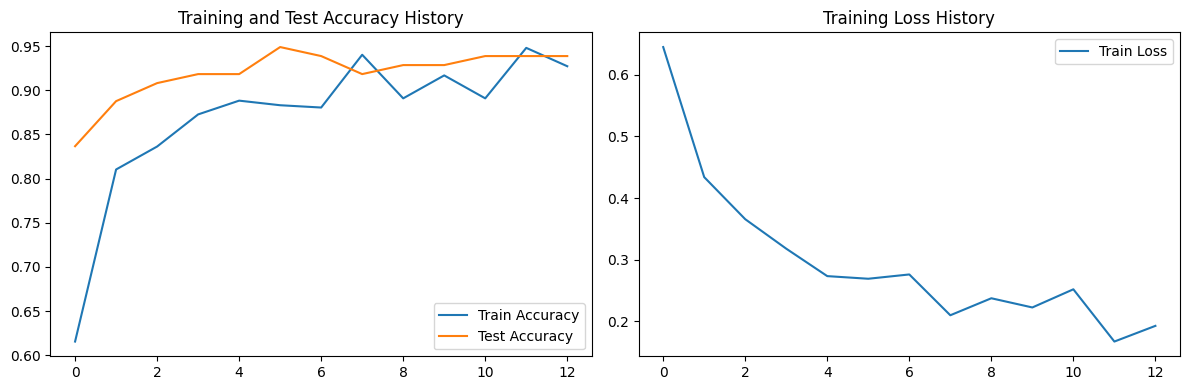

In [30]:
# 학습 결과 시각화
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(test_acc_hist, label='Test Accuracy')
plt.title('Training and Test Accuracy History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_hist, label='Train Loss')
plt.title('Training Loss History')
plt.legend()

plt.tight_layout()
plt.show()

### 6. Conclusion

- 이제 실제로 얼마나 잘 예측했는지 확인해보자.

In [31]:
# 이미지 출력 함수
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # 기울기에는 영향 주지 않게 기존 텐서 복사(메모리 새롭게 할당)
    image = image.transpose(1,2,0)
    image=image*(np.array((0.5,0.5,0.5))+np.array((0.5,0.5,0.5)))  
    image = image.clip(0,1) # 입력값을 0과 1사이로 제한(0 미만, 1이상인 값은 각각 0,1이 됨)
    return image

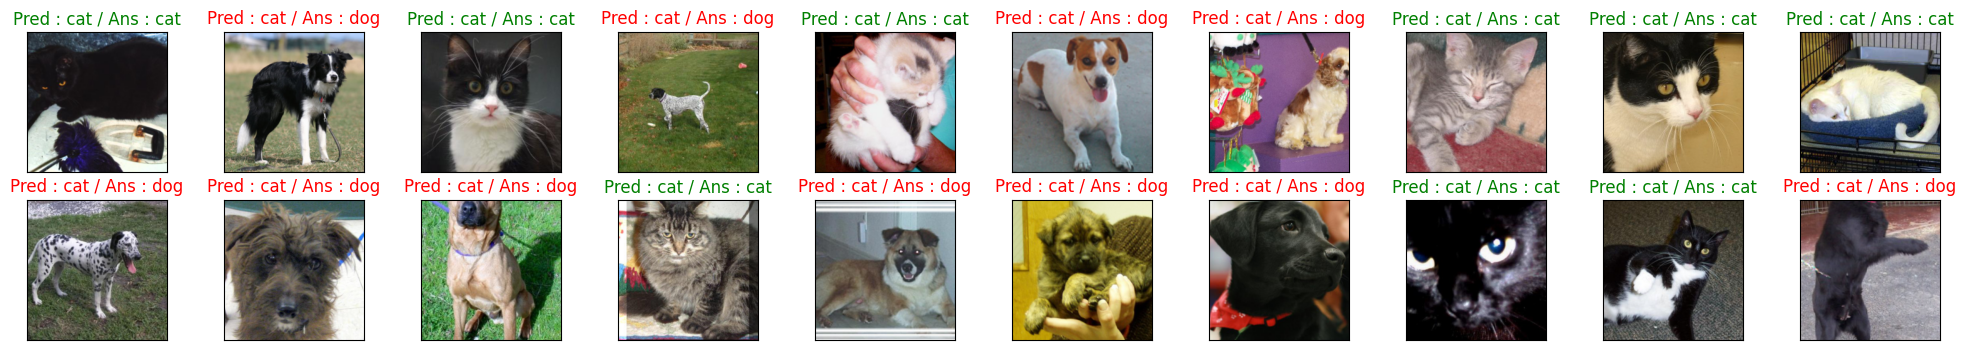

<Figure size 640x480 with 0 Axes>

In [32]:
# 레이블 정보
classes = {0 : 'cat', 1 : 'dog'}

# 데이터로더의 데이터를 하나씩 꺼냄
image, labels = next(iter(test_loader))

output = model(image)
_, preds = torch.max(output, 1)


fig=plt.figure(figsize=(25,4))  

for idx in np.arange(20):  
    ax=fig.add_subplot(2,10,idx+1,xticks=[],yticks=[])  
    plt.imshow(im_convert(image[idx]))  
    a.set_title(classes[labels[i].item()])
    ax.set_title("Pred : {} / Ans : {}".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
 
plt.show()  
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

- 오답인 경우를 보면 정답이 dog인데 cat이라고 예측한 경우 밖에 없다.
- cat에 대한 학습이 부족하다고 할 수 있겠다.